In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_full = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=False, transform=transform_train)
train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
cifar10_train, cifar10_val = random_split(cifar10_full, [train_size, val_size])

cifar10_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=False, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# BasicBlock for ResNet-18 with dropout
class BasicBlockRes18(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, dropout_p=0.3):
        super(BasicBlockRes18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_p)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.dropout(out)
        out = self.relu(out)
        return out

# Definition of ResNet-18 with dropout
class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2, stride=1, dropout_p=dropout_p)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout_p=dropout_p)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_p=dropout_p)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout_p=dropout_p)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlockRes18.expansion, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride, dropout_p):
        layers = []
        layers.append(BasicBlockRes18(self.in_channels, out_channels, stride, dropout_p))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlockRes18(self.in_channels, out_channels, stride=1, dropout_p=dropout_p))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
# load model
model = ResNet18(num_classes=10).to(device)
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlockRes18(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): BasicBlockRes18(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, k

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 11173962


In [6]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 1.5472, Val Loss: 1.2079, Val Acc: 0.5588
Epoch 2/30: Train Loss: 1.1305, Val Loss: 1.3417, Val Acc: 0.5490
Epoch 3/30: Train Loss: 0.9521, Val Loss: 0.9561, Val Acc: 0.6558
Epoch 4/30: Train Loss: 0.8350, Val Loss: 0.8504, Val Acc: 0.7032
Epoch 5/30: Train Loss: 0.7415, Val Loss: 0.7571, Val Acc: 0.7300
Epoch 6/30: Train Loss: 0.6658, Val Loss: 0.6188, Val Acc: 0.7802
Epoch 7/30: Train Loss: 0.6088, Val Loss: 0.6058, Val Acc: 0.7928
Epoch 8/30: Train Loss: 0.5618, Val Loss: 0.5662, Val Acc: 0.8012
Epoch 9/30: Train Loss: 0.5194, Val Loss: 0.5178, Val Acc: 0.8244
Epoch 10/30: Train Loss: 0.4933, Val Loss: 0.4804, Val Acc: 0.8308
Epoch 11/30: Train Loss: 0.4640, Val Loss: 0.4768, Val Acc: 0.8368
Epoch 12/30: Train Loss: 0.4374, Val Loss: 0.4407, Val Acc: 0.8420
Epoch 13/30: Train Loss: 0.4114, Val Loss: 0.4179, Val Acc: 0.8604
Epoch 14/30: Train Loss: 0.3987, Val Loss: 0.3938, Val Acc: 0.8604
Epoch 15/30: Train Loss: 0.3735, Val Loss: 0.3788, Val Acc: 0.8702
Epoc

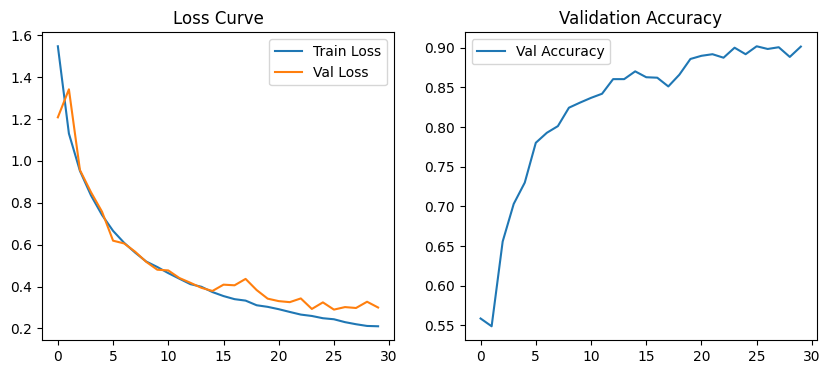

In [7]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p3_10_dropout_ResNet18_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar10_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.9034037148940676
Test Recall: 0.9016
Test F1 Score: 0.9009212520361348

Confusion Matrix:
 [[915   5  22   7   9   4   0   4  15  19]
 [  5 964   0   1   0   0   0   1   3  26]
 [ 32   2 855  25  28  23  15  12   3   5]
 [ 12   2  23 707  39 175  15  16   2   9]
 [  4   1  13  12 932  13   4  17   2   2]
 [  3   1  13  23  24 916   3  16   0   1]
 [  5   2  27  32  15  11 900   3   2   3]
 [  9   0   6   6  17  23   1 934   0   4]
 [ 23   7   2   4   1   1   0   1 939  22]
 [  4  35   2   2   0   1   0   0   2 954]]

Classification Report:
               precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.95      0.96      0.95      1000
        bird       0.89      0.85      0.87      1000
         cat       0.86      0.71      0.78      1000
        deer       0.88      0.93      0.90      1000
         dog       0.78      0.92      0.85      1000
        frog       0.96      0.90      0.93      1000
  

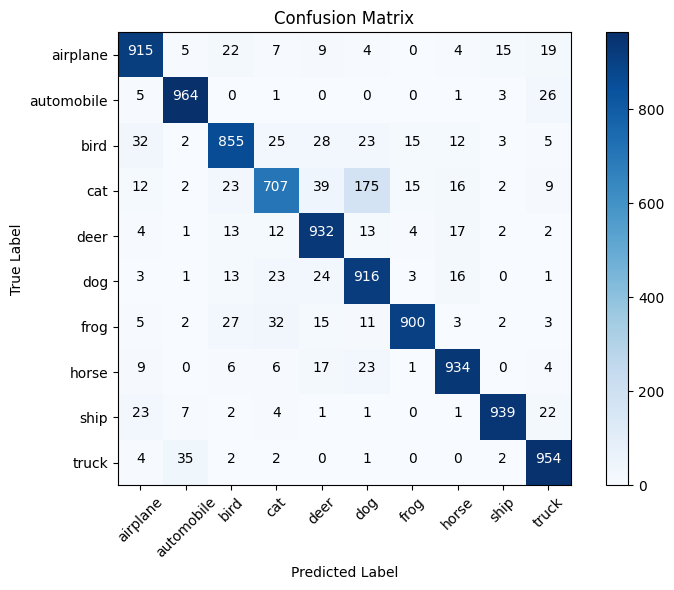

In [10]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar10_test.classes))
plt.xticks(tick_marks, cifar10_test.classes, rotation=45)
plt.yticks(tick_marks, cifar10_test.classes)

# Annotate the confusion matrix cells with the numeric values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p3_10_dropout_ResNet18_matrix.png")
plt.show()